In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'torch'

In [2]:
model_name = 'albert-base-v2'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels = 4)
label_encoder = LabelEncoder()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [3]:
train_file = 'twitter_training.csv'
val_file = 'twitter_validation.csv'

In [4]:
print(torch.cuda.is_available())

True


In [5]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, data, text_column, sentiment_column, graph, max_num_neighbors):
        self.data = data
        self.text_column = text_column
        self.sentiment_column = sentiment_column
        self.graph = graph
        self.max_num_neighbors = max_num_neighbors

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx, self.text_column]
        sentiment = self.data.iloc[idx, self.sentiment_column]
        if pd.isnull(text):
            text = None  # Replace missing text with an empty string

        if pd.isnull(sentiment):
            sentiment = 0  # Replace missing sentiment with a default value (0 in this example)

        encoding = tokenizer.encode_plus(
            str(text),
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        neighbors = list(self.graph.neighbors(idx))

        if len(neighbors) < self.max_num_neighbors:
            neighbors += [0] * (self.max_num_neighbors - len(neighbors))
        else:
            neighbors = neighbors[:self.max_num_neighbors]

        additional_features = torch.tensor(neighbors, dtype=torch.long).unsqueeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'sentiment': sentiment,
            'additional_features': additional_features
        }


In [6]:

train_data = pd.read_csv(train_file)
train_data = train_data.iloc[:len(train_data)//15, :]
graph = nx.Graph()
# Add nodes to the graph
graph.add_nodes_from(range(len(train_data)))

# Add edges to the graph (example: connect nodes 0 and 1)
graph.add_edge(0, 1)
max_num_neighbors = max(graph.degree, key=lambda x: x[1])[1]
train_dataset = SentimentDataset(train_data, text_column=3, sentiment_column=2, graph=graph, max_num_neighbors=max_num_neighbors )
val_data = pd.read_csv(val_file)
val_dataset = SentimentDataset(val_data, text_column=3, sentiment_column=2, graph=graph, max_num_neighbors=max_num_neighbors)

label_encoder.fit(train_data.iloc[: ,2])
print(train_dataset.__len__())

print(label_encoder.classes_)

4978
['Irrelevant' 'Negative' 'Neutral' 'Positive']


In [16]:
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()
checkpoint_path = "model_checkpoint.pt"

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = label_encoder.transform(batch['sentiment'])
        labels = torch.LongTensor(labels).to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Loss': loss.item(), 'GPU Memory': torch.cuda.memory_allocated(device=device)})

    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {average_loss}")

    # Evaluation on validation data
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = label_encoder.transform(batch['sentiment'])
            labels = torch.LongTensor(labels).to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            _, predicted_labels = torch.max(outputs.logits, dim=1)

            total_correct += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, checkpoint_path)
    accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {accuracy}")


Epoch 1/5 - Average Loss: 0.5942340768323569
Validation Accuracy: 0.5685685685685685


Epoch 2/5 - Average Loss: 0.15854580796893272
Validation Accuracy: 0.5115115115115115


Epoch 3/5 - Average Loss: 0.1006263473428439
Validation Accuracy: 0.5725725725725725


Epoch 4/5 - Average Loss: 0.07697831928493817
Validation Accuracy: 0.5815815815815816


Epoch 5/5 - Average Loss: 0.0832948047806207
Validation Accuracy: 0.5245245245245245


In [8]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [15]:
input_sentence = "kjashdfkjhasdkjf"
encoding = tokenizer.encode_plus(
    input_sentence,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

In [16]:
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    _, predicted_label = torch.max(outputs.logits, dim=1)

predicted_sentiment = label_encoder.inverse_transform(predicted_label.cpu().tolist())[0]
print(f"Input Sentence: {input_sentence}")
print(f"Predicted Sentiment: {predicted_sentiment}")

Input Sentence: kjashdfkjhasdkjf
Predicted Sentiment: Irrelevant


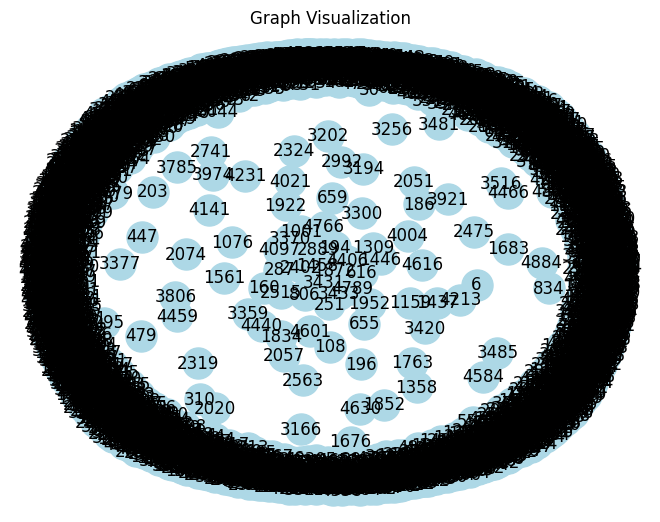

In [18]:
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
plt.title('Graph Visualization')
plt.show()

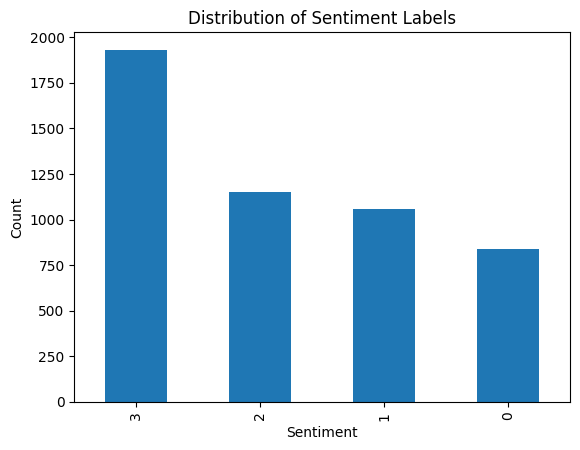

In [11]:
sentiment_counts = pd.Series(label_encoder.transform(train_data.iloc[:, 2])).value_counts()

# Plot the bar graph
sentiment_counts.plot(kind='bar')

# Set labels and title
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')

# Show the graph
plt.show()